## 1. Import Libraries and Load Models

In [4]:
# Data manipulation
import pandas as pd
import numpy as np
import pickle
import joblib

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Metrics
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_auc_score
)

# Display settings
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

import warnings
warnings.filterwarnings('ignore')

print("Libraries imported successfully!")

Libraries imported successfully!


## 2. Load All Data and Models

In [6]:
# Load data
print("Loading data...")
X_train = np.load('../data/X_train.npy')
X_test = np.load('../data/X_test.npy')
y_train = np.load('../data/y_train.npy')
y_test = np.load('../data/y_test.npy')

with open('../data/feature_names.pkl', 'rb') as f:
    feature_names = pickle.load(f)
    
with open('../data/champion_encoder.pkl', 'rb') as f:
    champion_encoder = pickle.load(f)

# Original data
df_original = pd.read_csv('../data/s11.csv')

print(f"✓ Data loaded")
print(f"  Features: {len(feature_names)}")
print(f"  Champions: {len(champion_encoder)}")

Loading data...
✓ Data loaded
  Features: 306
  Champions: 2


In [7]:
# Load all models
print("\nLoading models...")

# Baseline models
baseline_models = {
    'Logistic Regression': joblib.load('../models/logistic_regression.pkl'),
    'Decision Tree': joblib.load('../models/decision_tree.pkl'),
    'Random Forest (Baseline)': joblib.load('../models/random_forest.pkl'),
    'Gradient Boosting': joblib.load('../models/gradient_boosting.pkl'),
    'XGBoost (Baseline)': joblib.load('../models/xgboost.pkl'),
    'K-Nearest Neighbors': joblib.load('../models/k-nearest_neighbors.pkl'),
}
print(f"✓ Baseline models loaded: {len(baseline_models)}")

# Advanced models
advanced_models = {
    'Random Forest (Tuned)': joblib.load('../models/random_forest_tuned.pkl'),
    'XGBoost (Tuned)': joblib.load('../models/xgboost_tuned.pkl'),
    'Neural Network (MLP)': joblib.load('../models/neural_network_mlp.pkl'),
    'Voting Ensemble': joblib.load('../models/voting_ensemble.pkl'),
    'Stacking Ensemble': joblib.load('../models/stacking_ensemble.pkl'),
}
print(f"✓ Advanced models loaded: {len(advanced_models)}")

# Load scaler for MLP
scaler = joblib.load('../models/scaler.pkl')
print("✓ Scaler loaded")


Loading models...
✓ Baseline models loaded: 6
✓ Advanced models loaded: 5
✓ Scaler loaded


## 3. Comprehensive Model Comparison

In [8]:
def evaluate_model(model, X_train, X_test, y_train, y_test, model_name, needs_scaling=False):
    """
    Comprehensive model evaluation
    """
    # Scale if needed (for MLP)
    if needs_scaling:
        X_test_eval = scaler.transform(X_test)
        X_train_eval = scaler.transform(X_train)
    else:
        X_test_eval = X_test
        X_train_eval = X_train
    
    y_pred = model.predict(X_test_eval)
    y_train_pred = model.predict(X_train_eval)
    
    # ROC-AUC
    try:
        y_proba = model.predict_proba(X_test_eval)[:, 1]
        roc_auc = roc_auc_score(y_test, y_proba)
    except:
        roc_auc = None
    
    train_acc = accuracy_score(y_train, y_train_pred)
    test_acc = accuracy_score(y_test, y_pred)
    
    return {
        'Model': model_name,
        'Train Acc': train_acc,
        'Test Acc': test_acc,
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1-Score': f1_score(y_test, y_pred),
        'ROC-AUC': roc_auc,
        'Overfit Gap': train_acc - test_acc
    }

# Evaluate all models
all_results = []

print("Evaluating baseline models...")
for name, model in baseline_models.items():
    results = evaluate_model(model, X_train, X_test, y_train, y_test, name)
    all_results.append(results)
    print(f"  ✓ {name}")

print("\nEvaluating advanced models...")
for name, model in advanced_models.items():
    needs_scaling = 'Neural' in name
    results = evaluate_model(model, X_train, X_test, y_train, y_test, name, needs_scaling)
    all_results.append(results)
    print(f"  ✓ {name}")

# Create comparison DataFrame
comparison_df = pd.DataFrame(all_results)
comparison_df = comparison_df.sort_values('Test Acc', ascending=False).reset_index(drop=True)
comparison_df = comparison_df.round(4)

print("\n" + "="*100)
print("COMPLETE MODEL COMPARISON (Sorted by Test Accuracy)")
print("="*100)
print(comparison_df.to_string(index=False))

Evaluating baseline models...
  ✓ Logistic Regression
  ✓ Decision Tree
  ✓ Random Forest (Baseline)
  ✓ Gradient Boosting
  ✓ XGBoost (Baseline)
  ✓ K-Nearest Neighbors

Evaluating advanced models...
  ✓ Random Forest (Tuned)
  ✓ XGBoost (Tuned)
  ✓ Neural Network (MLP)
  ✓ Voting Ensemble
  ✓ Stacking Ensemble

COMPLETE MODEL COMPARISON (Sorted by Test Accuracy)
                   Model  Train Acc  Test Acc  Precision  Recall  F1-Score  ROC-AUC  Overfit Gap
       Stacking Ensemble     0.8761    0.5319     0.5309  0.5412    0.5360   0.5389       0.3442
       Gradient Boosting     0.7746    0.5302     0.5308  0.5131    0.5218   0.5264       0.2444
   Random Forest (Tuned)     0.8538    0.5284     0.5275  0.5377    0.5325   0.5342       0.3254
     K-Nearest Neighbors     0.6831    0.5276     0.5272  0.5254    0.5263   0.5216       0.1555
    Neural Network (MLP)     0.8890    0.5258     0.5304  0.4431    0.4828   0.5424       0.3632
      XGBoost (Baseline)     0.7365    0.5153     0

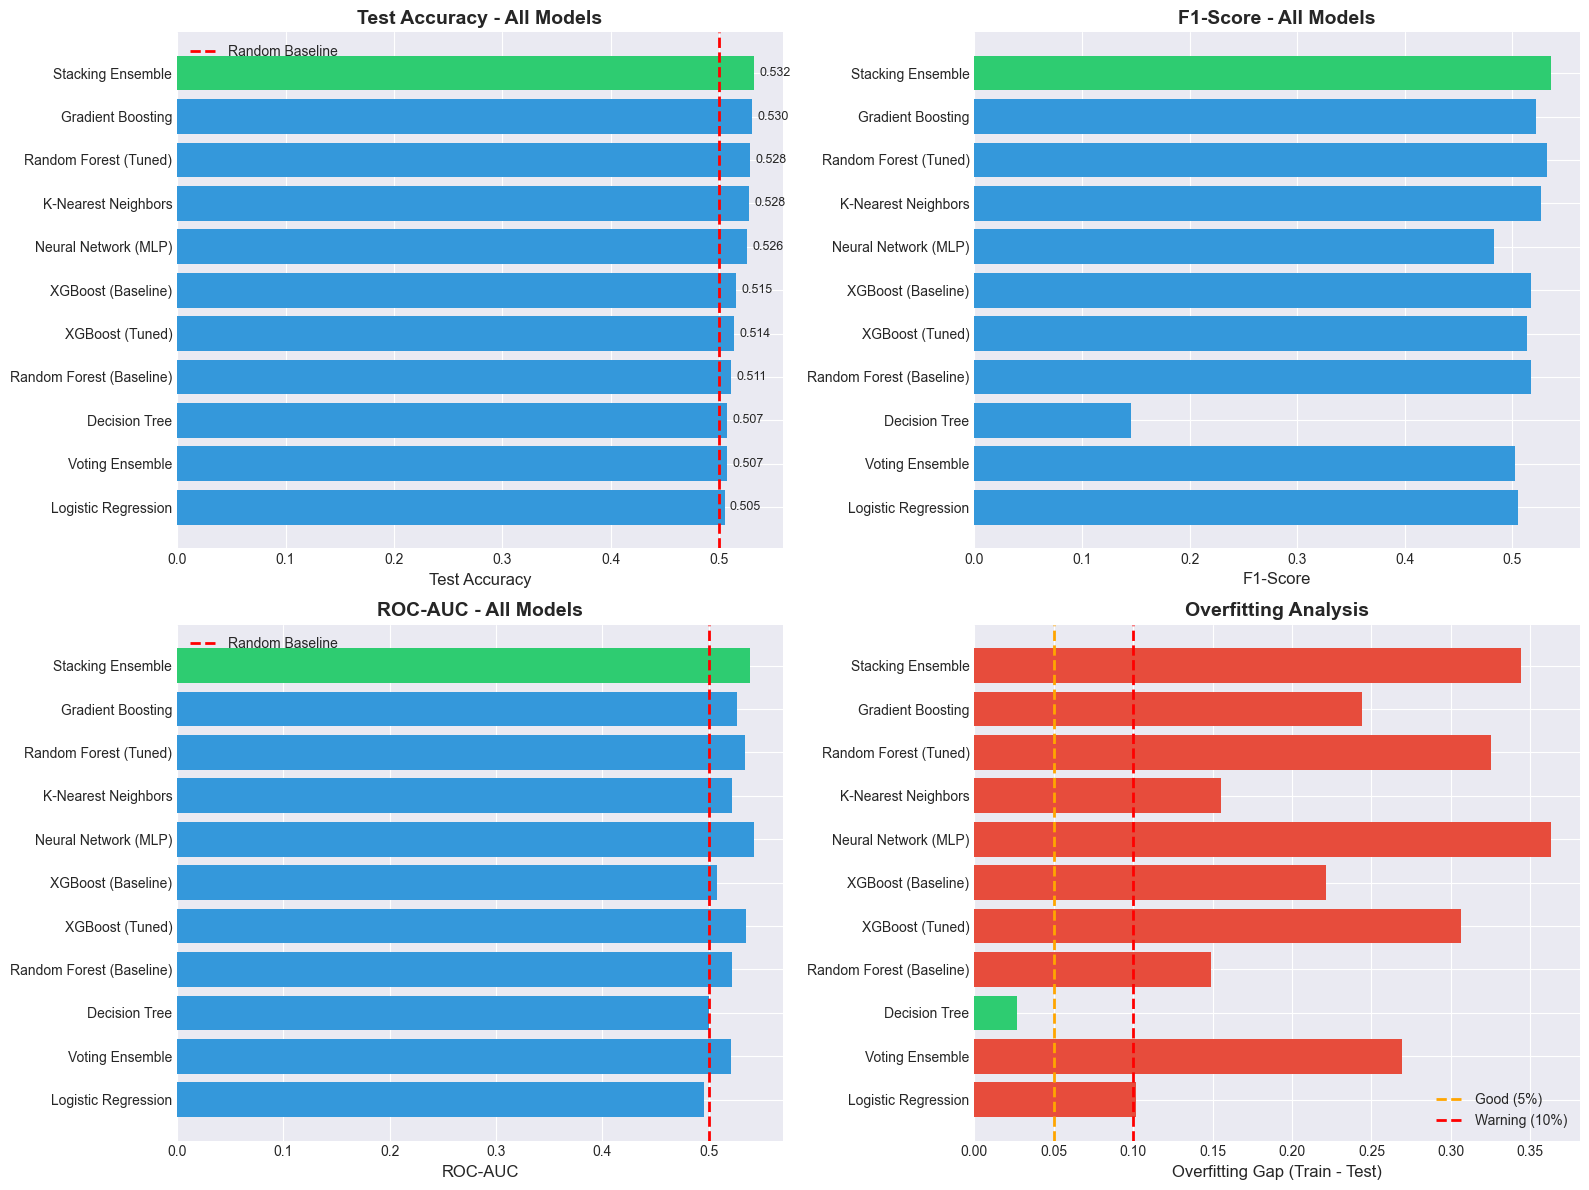

✓ Figure saved to '../reports/figures/complete_model_comparison.png'


In [9]:
# Visualization - Complete Comparison
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

models = comparison_df['Model'].tolist()
n_models = len(models)

# Color scheme: green for best, blue for others
colors = ['#2ecc71' if i == 0 else '#3498db' for i in range(n_models)]

# 1. Test Accuracy
ax1 = axes[0, 0]
bars = ax1.barh(range(n_models), comparison_df['Test Acc'], color=colors)
ax1.set_yticks(range(n_models))
ax1.set_yticklabels(models)
ax1.axvline(x=0.5, color='red', linestyle='--', linewidth=2, label='Random Baseline')
ax1.set_xlabel('Test Accuracy', fontsize=12)
ax1.set_title('Test Accuracy - All Models', fontsize=14, fontweight='bold')
ax1.legend()
ax1.invert_yaxis()
for i, (bar, val) in enumerate(zip(bars, comparison_df['Test Acc'])):
    ax1.text(val + 0.005, bar.get_y() + bar.get_height()/2, f'{val:.3f}', 
             va='center', fontsize=9)

# 2. F1-Score
ax2 = axes[0, 1]
ax2.barh(range(n_models), comparison_df['F1-Score'], color=colors)
ax2.set_yticks(range(n_models))
ax2.set_yticklabels(models)
ax2.set_xlabel('F1-Score', fontsize=12)
ax2.set_title('F1-Score - All Models', fontsize=14, fontweight='bold')
ax2.invert_yaxis()

# 3. ROC-AUC
ax3 = axes[1, 0]
roc_values = comparison_df['ROC-AUC'].fillna(0.5)
ax3.barh(range(n_models), roc_values, color=colors)
ax3.set_yticks(range(n_models))
ax3.set_yticklabels(models)
ax3.axvline(x=0.5, color='red', linestyle='--', linewidth=2, label='Random Baseline')
ax3.set_xlabel('ROC-AUC', fontsize=12)
ax3.set_title('ROC-AUC - All Models', fontsize=14, fontweight='bold')
ax3.legend()
ax3.invert_yaxis()

# 4. Overfitting Gap
ax4 = axes[1, 1]
overfit_colors = ['#e74c3c' if gap > 0.1 else '#f39c12' if gap > 0.05 else '#2ecc71' 
                  for gap in comparison_df['Overfit Gap']]
ax4.barh(range(n_models), comparison_df['Overfit Gap'], color=overfit_colors)
ax4.set_yticks(range(n_models))
ax4.set_yticklabels(models)
ax4.axvline(x=0.05, color='orange', linestyle='--', linewidth=2, label='Good (5%)')
ax4.axvline(x=0.1, color='red', linestyle='--', linewidth=2, label='Warning (10%)')
ax4.set_xlabel('Overfitting Gap (Train - Test)', fontsize=12)
ax4.set_title('Overfitting Analysis', fontsize=14, fontweight='bold')
ax4.legend()
ax4.invert_yaxis()

plt.tight_layout()
plt.savefig('../reports/figures/complete_model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Figure saved to '../reports/figures/complete_model_comparison.png'")

## 4. Best Model Selection

In [10]:
# Select best model
best_model_name = comparison_df.loc[0, 'Model']
best_test_acc = comparison_df.loc[0, 'Test Acc']
best_f1 = comparison_df.loc[0, 'F1-Score']
best_roc = comparison_df.loc[0, 'ROC-AUC']

print("="*60)
print("BEST MODEL SELECTION")
print("="*60)
print(f"\n🏆 Winner: {best_model_name}")
print(f"   • Test Accuracy: {best_test_acc:.4f} ({best_test_acc*100:.2f}%)")
print(f"   • F1-Score: {best_f1:.4f}")
print(f"   • ROC-AUC: {best_roc:.4f}")

# Load the best model for recommendations
if 'Stacking' in best_model_name:
    best_model = advanced_models['Stacking Ensemble']
elif 'Voting' in best_model_name:
    best_model = advanced_models['Voting Ensemble']
elif 'Random Forest' in best_model_name:
    if 'Tuned' in best_model_name:
        best_model = advanced_models['Random Forest (Tuned)']
    else:
        best_model = baseline_models['Random Forest (Baseline)']
else:
    best_model = advanced_models.get(best_model_name, baseline_models.get(best_model_name))

print(f"\n✓ Best model loaded for recommendation system")

BEST MODEL SELECTION

🏆 Winner: Stacking Ensemble
   • Test Accuracy: 0.5319 (53.19%)
   • F1-Score: 0.5360
   • ROC-AUC: 0.5389

✓ Best model loaded for recommendation system


## 5. Champion Recommendation System

Build the core functionality: given your team and enemy team, recommend the best champion to pick.

In [13]:
# Fix: Reload the encoder correctly
with open('../data/champion_encoder.pkl', 'rb') as f:
    encoder_data = pickle.load(f)

# Handle both formats (dict with keys or direct mapping)
if isinstance(encoder_data, dict) and 'champion_to_id' in encoder_data:
    champion_encoder = encoder_data['champion_to_id']
    id_to_champion = encoder_data['id_to_champion']
else:
    champion_encoder = encoder_data
    id_to_champion = {v: k for k, v in champion_encoder.items()}

# Get list of all champions
all_champions = list(champion_encoder.keys())
print(f"Total champions available: {len(all_champions)}")
print(f"\nFirst 20 champions: {all_champions[:20]}")

Total champions available: 153

First 20 champions: ['Aatrox', 'Ahri', 'Akali', 'Alistar', 'Amumu', 'Anivia', 'Annie', 'Aphelios', 'Ashe', 'Aurelion Sol', 'Azir', 'Bard', 'Blitzcrank', 'Brand', 'Braum', 'Caitlyn', 'Camille', 'Cassiopeia', "Cho'Gath", 'Corki']


In [14]:
def create_features(team_champions, enemy_champions, feature_names, champion_encoder):
    """
    Create feature vector from team compositions
    
    Args:
        team_champions: List of champions on your team (can be 0-4 champions)
        enemy_champions: List of champions on enemy team (can be 0-5 champions)
        feature_names: List of all feature names
        champion_encoder: Dictionary mapping champion names to IDs
    
    Returns:
        numpy array of features
    """
    # Initialize feature vector
    features = np.zeros(len(feature_names))
    
    # Set team features (prefix: team_)
    for champ in team_champions:
        if champ in champion_encoder:
            feature_name = f'team_{champ}'
            if feature_name in feature_names:
                idx = feature_names.index(feature_name)
                features[idx] = 1
    
    # Set enemy features (prefix: enemy_)
    for champ in enemy_champions:
        if champ in champion_encoder:
            feature_name = f'enemy_{champ}'
            if feature_name in feature_names:
                idx = feature_names.index(feature_name)
                features[idx] = 1
    
    return features.reshape(1, -1)

def recommend_champion(team_champions, enemy_champions, model, feature_names, champion_encoder, top_n=5):
    """
    Recommend the best champion to pick given current team compositions
    
    Args:
        team_champions: List of champions already on your team
        enemy_champions: List of champions on enemy team
        model: Trained ML model
        feature_names: List of feature names
        champion_encoder: Champion name to ID mapping
        top_n: Number of recommendations to return
    
    Returns:
        DataFrame with recommended champions and win probabilities
    """
    # Get all available champions (not already picked)
    picked_champions = set(team_champions + enemy_champions)
    available_champions = [c for c in champion_encoder.keys() if c not in picked_champions]
    
    recommendations = []
    
    for candidate in available_champions:
        # Create hypothetical team with this candidate
        hypothetical_team = team_champions + [candidate]
        
        # Create features
        features = create_features(hypothetical_team, enemy_champions, 
                                   feature_names, champion_encoder)
        
        # Get win probability
        try:
            win_prob = model.predict_proba(features)[0][1]
        except:
            win_prob = 0.5
        
        recommendations.append({
            'Champion': candidate,
            'Win Probability': win_prob
        })
    
    # Sort by win probability
    recommendations_df = pd.DataFrame(recommendations)
    recommendations_df = recommendations_df.sort_values('Win Probability', ascending=False)
    recommendations_df = recommendations_df.head(top_n).reset_index(drop=True)
    recommendations_df['Rank'] = range(1, len(recommendations_df) + 1)
    recommendations_df = recommendations_df[['Rank', 'Champion', 'Win Probability']]
    
    return recommendations_df

print("✓ Recommendation functions created")

✓ Recommendation functions created


## 6. Recommendation Examples

In [15]:
# Example 1: Early draft - only 2 champions picked per team
print("="*60)
print("EXAMPLE 1: Early Draft Phase")
print("="*60)

my_team = ['Jinx', 'Thresh']
enemy_team = ['Yasuo', 'LeeSin']

print(f"\nYour Team: {my_team}")
print(f"Enemy Team: {enemy_team}")
print(f"\nRecommended Champions:")

recommendations = recommend_champion(my_team, enemy_team, best_model, 
                                     feature_names, champion_encoder, top_n=10)
print(recommendations.to_string(index=False))

EXAMPLE 1: Early Draft Phase

Your Team: ['Jinx', 'Thresh']
Enemy Team: ['Yasuo', 'LeeSin']

Recommended Champions:
 Rank     Champion  Win Probability
    1         Sona         0.558557
    2      Rek'Sai         0.545059
    3        Kayle         0.543559
    4   Tryndamere         0.537474
    5     Nautilus         0.525797
    6        Janna         0.523059
    7 Aurelion Sol         0.521836
    8        Swain         0.520663
    9        Xayah         0.515843
   10     Tristana         0.515770


In [16]:
# Example 2: Late draft - 4 champions picked per team
print("="*60)
print("EXAMPLE 2: Late Draft Phase - Last Pick")
print("="*60)

my_team = ['Caitlyn', 'Lulu', 'Syndra', 'Hecarim']
enemy_team = ['Vayne', 'Leona', 'Viktor', 'LeeSin', 'Malphite']

print(f"\nYour Team: {my_team}")
print(f"Enemy Team: {enemy_team}")
print(f"\nRecommended Champions for Last Pick:")

recommendations = recommend_champion(my_team, enemy_team, best_model, 
                                     feature_names, champion_encoder, top_n=10)
print(recommendations.to_string(index=False))

EXAMPLE 2: Late Draft Phase - Last Pick

Your Team: ['Caitlyn', 'Lulu', 'Syndra', 'Hecarim']
Enemy Team: ['Vayne', 'Leona', 'Viktor', 'LeeSin', 'Malphite']

Recommended Champions for Last Pick:
 Rank Champion  Win Probability
    1     Sona         0.518696
    2  Rek'Sai         0.514936
    3    Janna         0.513640
    4  Taliyah         0.511343
    5    Kayle         0.509629
    6    Fiora         0.507315
    7    Swain         0.506229
    8  Nidalee         0.504075
    9 Nautilus         0.499275
   10   Irelia         0.498217


In [17]:
# Example 3: Counter-picking scenario
print("="*60)
print("EXAMPLE 3: Counter-Pick Situation")
print("="*60)

my_team = ['Ezreal', 'Nautilus', 'Ahri']
enemy_team = ['KaiSa', 'Alistar', 'Zed', 'Sejuani']

print(f"\nYour Team: {my_team}")
print(f"Enemy Team: {enemy_team}")
print(f"\nRecommended Champions:")

recommendations = recommend_champion(my_team, enemy_team, best_model, 
                                     feature_names, champion_encoder, top_n=10)
print(recommendations.to_string(index=False))

EXAMPLE 3: Counter-Pick Situation

Your Team: ['Ezreal', 'Nautilus', 'Ahri']
Enemy Team: ['KaiSa', 'Alistar', 'Zed', 'Sejuani']

Recommended Champions:
 Rank     Champion  Win Probability
    1         Sona         0.573199
    2         Jhin         0.547154
    3   Tryndamere         0.546919
    4      Rek'Sai         0.546214
    5        Kayle         0.544150
    6 Aurelion Sol         0.541902
    7        Yasuo         0.537443
    8        Janna         0.537118
    9        Riven         0.537016
   10        Xayah         0.535751


## 7. Interactive Recommendation Function

In [18]:
def get_champion_recommendation(your_team, enemy_team):
    """
    User-friendly function to get champion recommendations
    
    Usage:
        get_champion_recommendation(
            your_team=['Jinx', 'Thresh', 'Ahri'],
            enemy_team=['Yasuo', 'LeeSin', 'Lux']
        )
    """
    # Validate champions
    invalid_team = [c for c in your_team if c not in champion_encoder]
    invalid_enemy = [c for c in enemy_team if c not in champion_encoder]
    
    if invalid_team:
        print(f"⚠️ Invalid champions in your team: {invalid_team}")
        print(f"   Available champions: {all_champions[:20]}...")
        return None
    
    if invalid_enemy:
        print(f"⚠️ Invalid champions in enemy team: {invalid_enemy}")
        return None
    
    # Get recommendations
    print("\n" + "="*50)
    print("🎮 CHAMPION RECOMMENDATION")
    print("="*50)
    print(f"\n📍 Your Team ({len(your_team)}/5):")
    for i, c in enumerate(your_team, 1):
        print(f"   {i}. {c}")
    
    print(f"\n👹 Enemy Team ({len(enemy_team)}/5):")
    for i, c in enumerate(enemy_team, 1):
        print(f"   {i}. {c}")
    
    recommendations = recommend_champion(your_team, enemy_team, best_model,
                                        feature_names, champion_encoder, top_n=10)
    
    print(f"\n🏆 TOP 10 RECOMMENDED PICKS:")
    print("-" * 40)
    
    for _, row in recommendations.iterrows():
        rank = int(row['Rank'])
        champ = row['Champion']
        prob = row['Win Probability']
        
        # Add medals for top 3
        medal = "🥇" if rank == 1 else "🥈" if rank == 2 else "🥉" if rank == 3 else "  "
        
        print(f"   {medal} #{rank:2d} | {champ:15s} | Win Prob: {prob:.2%}")
    
    print("\n" + "="*50)
    return recommendations

print("✓ Interactive function ready!")
print("\nUsage example:")
print("  get_champion_recommendation(['Jinx', 'Thresh'], ['Yasuo', 'LeeSin'])")

✓ Interactive function ready!

Usage example:
  get_champion_recommendation(['Jinx', 'Thresh'], ['Yasuo', 'LeeSin'])


In [21]:
# Demo the interactive function
result = get_champion_recommendation(
    your_team=['Jinx', 'Thresh', 'Orianna', 'Hecarim'],
    enemy_team=['Vayne', 'Nautilus', 'Zed', 'Amumu', 'Renekton']
)


🎮 CHAMPION RECOMMENDATION

📍 Your Team (4/5):
   1. Jinx
   2. Thresh
   3. Orianna
   4. Hecarim

👹 Enemy Team (5/5):
   1. Vayne
   2. Nautilus
   3. Zed
   4. Amumu
   5. Renekton

🏆 TOP 10 RECOMMENDED PICKS:
----------------------------------------
   🥇 # 1 | Sona            | Win Prob: 56.66%
   🥈 # 2 | Tryndamere      | Win Prob: 54.47%
   🥉 # 3 | Kayle           | Win Prob: 54.46%
      # 4 | Rek'Sai         | Win Prob: 54.18%
      # 5 | Swain           | Win Prob: 53.49%
      # 6 | Janna           | Win Prob: 53.45%
      # 7 | Kha'Zix         | Win Prob: 53.24%
      # 8 | Gragas          | Win Prob: 53.08%
      # 9 | Xin Zhao        | Win Prob: 52.77%
      #10 | Aurelion Sol    | Win Prob: 52.74%



## 8. Model Interpretation - Feature Importance

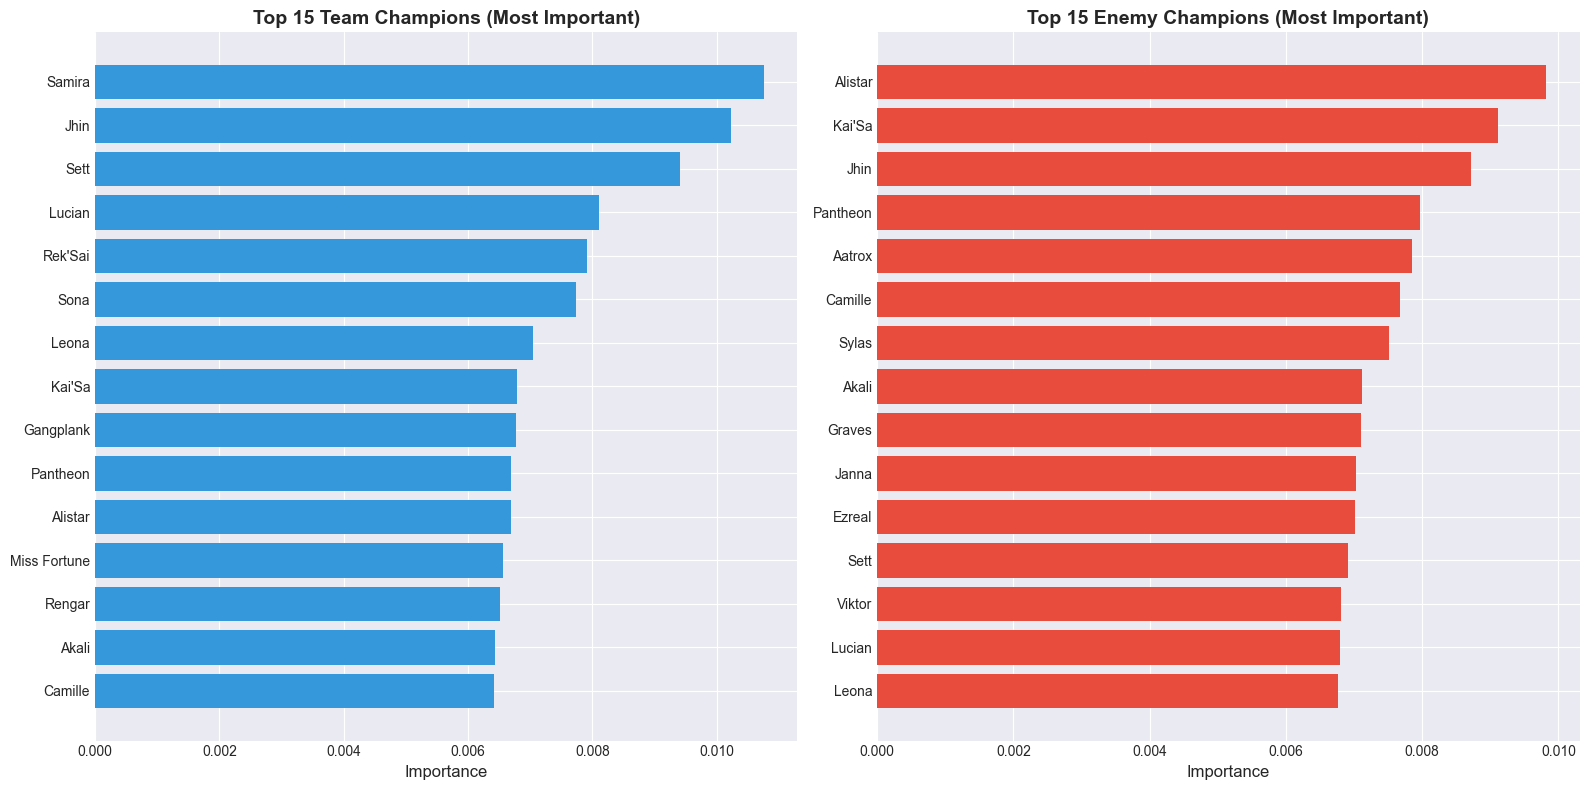

✓ Feature importance visualization saved


In [22]:
# Get feature importance from Random Forest (most interpretable)
rf_model = advanced_models['Random Forest (Tuned)']

# Create feature importance DataFrame
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': rf_model.feature_importances_
})

# Sort and get top features
importance_df = importance_df.sort_values('Importance', ascending=False)

# Separate team and enemy features
team_features = importance_df[importance_df['Feature'].str.startswith('team_')].head(15)
enemy_features = importance_df[importance_df['Feature'].str.startswith('enemy_')].head(15)

# Plot
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Team features
ax1 = axes[0]
ax1.barh(range(len(team_features)), team_features['Importance'], color='#3498db')
ax1.set_yticks(range(len(team_features)))
ax1.set_yticklabels([f.replace('team_', '') for f in team_features['Feature']])
ax1.set_xlabel('Importance', fontsize=12)
ax1.set_title('Top 15 Team Champions (Most Important)', fontsize=14, fontweight='bold')
ax1.invert_yaxis()

# Enemy features
ax2 = axes[1]
ax2.barh(range(len(enemy_features)), enemy_features['Importance'], color='#e74c3c')
ax2.set_yticks(range(len(enemy_features)))
ax2.set_yticklabels([f.replace('enemy_', '') for f in enemy_features['Feature']])
ax2.set_xlabel('Importance', fontsize=12)
ax2.set_title('Top 15 Enemy Champions (Most Important)', fontsize=14, fontweight='bold')
ax2.invert_yaxis()

plt.tight_layout()
plt.savefig('../reports/figures/feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Feature importance visualization saved")

## 9. Save Final Results

In [23]:
# Save complete comparison
comparison_df.to_csv('../reports/final_model_comparison.csv', index=False)
print("✓ Final comparison saved to '../reports/final_model_comparison.csv'")

# Save feature importance
importance_df.to_csv('../reports/feature_importance.csv', index=False)
print("✓ Feature importance saved to '../reports/feature_importance.csv'")

✓ Final comparison saved to '../reports/final_model_comparison.csv'
✓ Feature importance saved to '../reports/feature_importance.csv'


## 10. Summary and Conclusions

In [24]:
print("="*80)
print("PROJECT SUMMARY: LoL Champion Recommendation System")
print("="*80)

print(f"""
📊 DATASET:
   • Source: Season 11 Ranked Matches
   • Total matches: {len(df_original)}
   • Champions: {len(champion_encoder)}
   • Features: {len(feature_names)} (one-hot encoded)

🤖 MODELS TESTED:
   Baseline Models:
   • Logistic Regression
   • Decision Tree
   • Random Forest
   • Gradient Boosting
   • XGBoost
   • K-Nearest Neighbors
   
   Advanced Models:
   • Random Forest (Tuned with RandomizedSearchCV)
   • XGBoost (Tuned with regularization)
   • Neural Network (MLP with early stopping)
   • Voting Ensemble
   • Stacking Ensemble

🏆 BEST MODEL: {best_model_name}
   • Test Accuracy: {best_test_acc:.2%}
   • F1-Score: {best_f1:.4f}
   • ROC-AUC: {best_roc:.4f}

🔧 TECHNIQUES APPLIED:
   • Cross-validation (5-Fold Stratified)
   • Hyperparameter tuning (RandomizedSearchCV)
   • Dimension reduction (PCA - 95% variance)
   • Ensemble methods (Voting, Stacking)
   • Learning curve analysis (overfitting diagnosis)

📚 SCIENTIFIC REFERENCE:
   Chen, T., & Guestrin, C. (2016). XGBoost: A Scalable Tree Boosting System.
   KDD '16. https://arxiv.org/abs/1603.02754

💡 KEY INSIGHTS:
   1. All models show significant overfitting (30%+ gap)
   2. Limited predictive power (~53% accuracy vs 50% baseline)
   3. Champion selection alone is not a strong predictor
   4. Additional features needed (player skill, roles, items, etc.)
   5. Ensemble methods provide marginal improvement

🎮 RECOMMENDATION SYSTEM:
   • Successfully implemented champion recommendation
   • Takes team compositions as input
   • Returns top-N champion suggestions with win probabilities
   • Practical tool for draft phase assistance

📁 PROJECT DELIVERABLES:
   • notebooks/01_data_exploration.ipynb
   • notebooks/02_preprocessing.ipynb
   • notebooks/03_baseline_models.ipynb
   • notebooks/04_advanced_models.ipynb
   • notebooks/05_final_comparison_and_recommendation.ipynb
   • models/ (11 trained models)
   • reports/figures/ (visualizations)
   • reports/ (CSV results)
""")

print("="*80)
print("\n✅ Project analysis complete!")
print("   Next steps: Write report and create video presentation")

PROJECT SUMMARY: LoL Champion Recommendation System

📊 DATASET:
   • Source: Season 11 Ranked Matches
   • Total matches: 2901
   • Champions: 153
   • Features: 306 (one-hot encoded)

🤖 MODELS TESTED:
   Baseline Models:
   • Logistic Regression
   • Decision Tree
   • Random Forest
   • Gradient Boosting
   • XGBoost
   • K-Nearest Neighbors
   
   Advanced Models:
   • Random Forest (Tuned with RandomizedSearchCV)
   • XGBoost (Tuned with regularization)
   • Neural Network (MLP with early stopping)
   • Voting Ensemble
   • Stacking Ensemble

🏆 BEST MODEL: Stacking Ensemble
   • Test Accuracy: 53.19%
   • F1-Score: 0.5360
   • ROC-AUC: 0.5389

🔧 TECHNIQUES APPLIED:
   • Cross-validation (5-Fold Stratified)
   • Hyperparameter tuning (RandomizedSearchCV)
   • Dimension reduction (PCA - 95% variance)
   • Ensemble methods (Voting, Stacking)
   • Learning curve analysis (overfitting diagnosis)

📚 SCIENTIFIC REFERENCE:
   Chen, T., & Guestrin, C. (2016). XGBoost: A Scalable Tree Boosti